In [1]:
pip install findspark

Note: you may need to restart the kernel to use updated packages.


In [30]:
import findspark
from pyspark.sql.functions import col, current_date, datediff, floor, when
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

In [5]:
findspark.init()

In [6]:
from pyspark.sql import SparkSession

In [7]:
spark = SparkSession.builder.appName("Read Parquet").getOrCreate()

/spark-3.4.3-bin-without-hadoop/python/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


In [73]:
df = spark.read.parquet("hdfs:///data.parquet")

In [101]:
df.show(10); df.count()

+----------------+----------+--------------------+---------+--------------------+----+---------+
|             Tên| Ngày sinh|             Địa chỉ|Giới tính|       Số điện thoại|Tuổi|Nhóm tuổi|
+----------------+----------+--------------------+---------+--------------------+----+---------+
|Rachael Guerrero|1926-07-21|     6089 Moss Fords|      Nam| (383)406-4848x16592|  97|    90-99|
|  Stephen Church|1918-11-14|      1927 Le Canyon|      Nam|001-578-324-5543x...| 105|     100+|
| Sonia Cervantes|1915-03-12|07340 Mitchell Gr...|      Nam|  850-901-0649x67818| 109|     100+|
|  Michaela Kelly|1922-01-28|   5026 Bright Ranch|       Nữ|          5026801700| 102|     100+|
|  Cindy Williams|1995-02-11|  526 Bianca Village|       Nữ|001-941-391-6346x...|  29|    20-29|
|  George Johnson|1941-06-19|   86696 Erin Stream|      Nam|001-474-660-8520x...|  82|    80-89|
|    David Harper|2021-07-15|       3495 Alan Way|       Nữ|        530-303-2953|   2|      0-9|
|     Jerry Hardy|1918-12-01| 

1000000

In [75]:
# Calculate age
df = df.withColumn("Tuổi", floor(datediff(current_date(), col("Ngày sinh")) / 365.25))


In [76]:
# Define age groups using when
df = df.withColumn("Nhóm tuổi",
                   when(col("Tuổi") < 10, "0-9")
                   .when(col("Tuổi") < 20, "10-19")
                   .when(col("Tuổi") < 30, "20-29")
                   .when(col("Tuổi") < 40, "30-39")
                   .when(col("Tuổi") < 50, "40-49")
                   .when(col("Tuổi") < 60, "50-59")
                   .when(col("Tuổi") < 70, "60-69")
                   .when(col("Tuổi") < 80, "70-79")
                   .when(col("Tuổi") < 90, "80-89")
                   .when(col("Tuổi") < 100, "90-99")
                   .otherwise("100+"))


In [77]:
df.show()

+--------------------+----------+--------------------+---------+--------------------+----+---------+
|                 Tên| Ngày sinh|             Địa chỉ|Giới tính|       Số điện thoại|Tuổi|Nhóm tuổi|
+--------------------+----------+--------------------+---------+--------------------+----+---------+
|    Rachael Guerrero|1926-07-21|     6089 Moss Fords|      Nam| (383)406-4848x16592|  97|    90-99|
|      Stephen Church|1918-11-14|      1927 Le Canyon|      Nam|001-578-324-5543x...| 105|     100+|
|     Sonia Cervantes|1915-03-12|07340 Mitchell Gr...|      Nam|  850-901-0649x67818| 109|     100+|
|      Michaela Kelly|1922-01-28|   5026 Bright Ranch|       Nữ|          5026801700| 102|     100+|
|      Cindy Williams|1995-02-11|  526 Bianca Village|       Nữ|001-941-391-6346x...|  29|    20-29|
|      George Johnson|1941-06-19|   86696 Erin Stream|      Nam|001-474-660-8520x...|  82|    80-89|
|        David Harper|2021-07-15|       3495 Alan Way|       Nữ|        530-303-2953|   2| 

In [98]:
age_gender_df = df.groupBy("Nhóm tuổi", "Giới tính").count()


In [93]:
age_gender_df.show()

+---------+---------+-----+
|Nhóm tuổi|Giới tính|count|
+---------+---------+-----+
|    70-79|      Nam|43012|
|    90-99|       Nữ|42930|
|    40-49|      Nam|43225|
|    70-79|       Nữ|42888|
|    10-19|       Nữ|42971|
|    20-29|       Nữ|42610|
|    50-59|      Nam|43202|
|    80-89|      Nam|43489|
|    20-29|      Nam|43068|
|      0-9|       Nữ|43392|
|    60-69|      Nam|43270|
|    80-89|       Nữ|42851|
|    90-99|      Nam|42868|
|    50-59|       Nữ|43160|
|     100+|      Nam|68813|
|    30-39|      Nam|43186|
|    10-19|      Nam|43195|
|    40-49|       Nữ|43173|
|      0-9|      Nam|43019|
|     100+|       Nữ|69231|
+---------+---------+-----+
only showing top 20 rows



In [94]:
# Function to convert age groups to sort keys
def age_group_to_sort_key(age_group):
    if age_group == "100+":
        return 100
    else:
        # Return the lower bound of the age range
        return int(age_group.split('-')[0])

In [99]:
age_gender_df= (age_gender_df.withColumn("Sort Key", age_group_to_sort_key_udf(df["Nhóm tuổi"]))
                .orderBy("Sort Key")
                .toPandas())


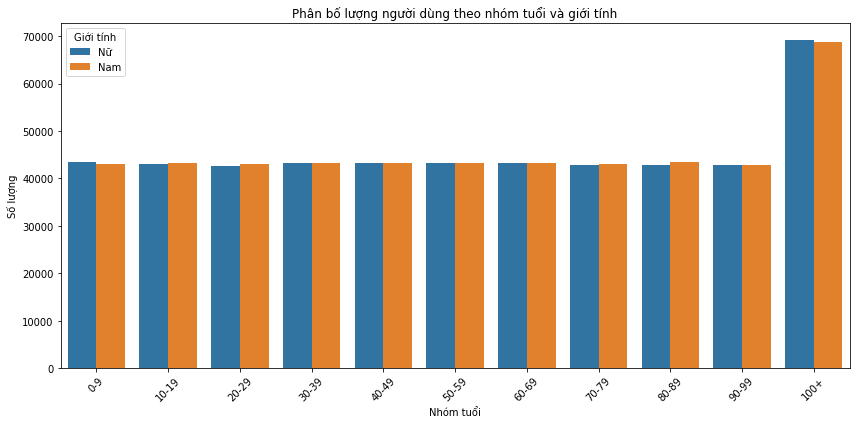

In [100]:
plt.figure(figsize=(12, 6))
sns.barplot(x="Nhóm tuổi", y="count", hue="Giới tính", data=age_gender_df)
plt.title("Phân bố lượng người dùng theo nhóm tuổi và giới tính")
plt.xlabel("Nhóm tuổi")
plt.ylabel("Số lượng")
plt.xticks(rotation=45)
plt.legend(title="Giới tính")
plt.tight_layout()
plt.show()